# 미니프로젝트3 회귀

# **1. 라이브러리 및 데이터**


In [ ]:
# matplotlib 한글 깨짐방지
# 아래코드 실행후 '런타임 다시시작' 후 모듈 불러오기
# 참고 블로그: https://teddylee777.github.io/colab/colab-korean
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (13.4 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123630 files and direc

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') #matplotlib 한글 깨짐 방지

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/2024-2 ESAA/Data/movie_data/movies_train.csv')
test = pd.read_csv("/content/drive/MyDrive/2024-2 ESAA/Data/movie_data/movies_test.csv")
submission = pd.read_csv('/content/drive/MyDrive/2024-2 ESAA/Data/movie_data/submission.csv')

In [ ]:
# 시드 고정
import os
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# **2. 탐색적 자료분석(EDA)**



## 1) 일부 데이터 미리보기


+ title : 영화의 제목
+ distributor : 배급사
+ genre : 장르
+ release_time : 개봉일
+ time : 상영시간(분)
+ screening_rat : 상영등급
+ director : 감독이름
+ dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
+ dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
+ num_staff : 스텝수
+ num_actor : 주연배우수
+ box_off_num : 관객수

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
submission.head()

## 2) 데이터 요약


In [ ]:
print(train.shape)
print(test.shape)

- 600개의 데이터와 12개의 변수가 존재


In [ ]:
train.info()

In [ ]:
test.info()

## 3) 데이터의 요약통계량 확인

In [ ]:
pd.options.display.float_format = '{:.1f}'.format

In [ ]:
train.describe()

In [ ]:
test.describe()

## 4) 결측치 확인 및 데이터 전처리


In [ ]:
train.isna().sum()

- dir_prev_bfnum 변수에 결측값이 330개 존재한다.

### (1) dir_prev_bfnum

- dir_prev_bfnum이 결측값으로 존재하는 데이터들은 전부 dir_prev_num이 0인 영화들이다. 즉, 감독의 이전작품이 존재 하지 않은 경우이다. 따라서 dir_prev_bfnum에 있는 결측값은 전부 0으로 채운다.

In [ ]:
# 결측치 처리 (dir_prev_bfnum의 결측값 0으로 채우기)
train['dir_prev_bfnum'].fillna(0, inplace=True)
test['dir_prev_bfnum'].fillna(0, inplace=True)

In [ ]:
# train 데이터 'dir_prev_bfnum' 이상치 확인
sns.boxplot(train.dir_prev_bfnum)

In [ ]:
# train 데이터 'dir_prev_bfnum' 이상치 삭제
train = train.sort_values(by='dir_prev_bfnum', ascending=False).iloc[1:]

### (2) time

In [ ]:
# test 데이터 'time' 이상치 확인
sns.boxplot(test.time)

In [ ]:
# test 데이터 'time' 이상치 평균값으로 대체
test.at[test[test['time']>= 1000].index[0], 'time'] = int(test['time'].mean())

### (3) 개봉일 (realease_time)

- release_time은 시간에 관련된 데이터인데 int형으로 인식되고 있다. release_time을 datetime형식으로 변환한다.

In [ ]:
train['release_time'] = pd.to_datetime(train['release_time'])
test['release_time'] = pd.to_datetime(test['release_time'])

* 분석 과정에서의 편의를 위해 release_time 변수를 개봉 연도, 분기, 월, 계절, 요일로 나눈 변수를 생성

In [ ]:
# 연도, 분기, 월, 요일 변수 생성
train['release_year'] = train['release_time'].dt.year
train['release_month'] = train['release_time'].dt.month

test['release_year'] = test['release_time'].dt.year
test['release_month'] = test['release_time'].dt.month

In [ ]:
# 확인
train[['release_time','release_year','release_month']].head()

### (4) 배급사

In [ ]:
# 같은 배급사지만 다르게 표기되어 있는 경우 통합하기

def distr_cleaning (x) :
    if 'CGV' in x or '무비꼴라쥬' in x :
        return 'CGV'
    elif 'E&M' in x or 'CJ엔터테인먼트' in x :
        return 'CJ E&M'
    elif '롯데' in x :
        return '롯데엔터테인먼트'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x :
        return '싸이더스'
    elif '마운틴픽처스' in x or '마운틴픽쳐스' in x :
        return '마운틴픽쳐스'
    elif '메가박스중앙플러스엠' in x or '메가박스플러스엠' in x :
        return '메가박스플러스엠'
    elif '쇼박스' in x :
        return '쇼박스'
    elif '조이앤시네마' in x or '조이앤컨텐츠그룹' in x :
        return '조이앤'
    elif '타임스토리' in x :
        return '타임스토리'
    elif '프리비젼' in x :
        return '프리비젼'
    elif '리틀빅픽' in x :
        return '리틀빅픽쳐스'
    else :
        return x

train['distributor'] = train['distributor'].str.replace('\(주\)', '').str.replace(' ', '')
train['distributor'] = train['distributor'].apply(distr_cleaning)
test['distributor'] = test['distributor'].str.replace('\(주\)', '').str.replace(' ', '')
test['distributor'] = test['distributor'].apply(distr_cleaning)

## 5) 변수 정리 (원핫인코딩)

### (1) 상영등급 (screening-rat)

In [ ]:
# 원 핫 인코딩
train = pd.get_dummies(train, columns=['screening_rat'])
test = pd.get_dummies(test, columns=['screening_rat'])

### (2) 장르

In [ ]:
train.head(3)

In [ ]:
train.groupby('genre').box_off_num.mean().sort_values()

In [ ]:
# 원 핫 인코딩
train = pd.get_dummies(train, columns=['genre'])
test = pd.get_dummies(test, columns=['genre'])

### (3) 감독 (director)

In [ ]:
# 감독 변수 제거
train=train.drop(['director'], axis=1)
test=test.drop(['director'], axis=1)

### (4) 배급사

In [ ]:
# 상위 14개 배급사를 제외한 배급사는 '기타'로 처리
dist_train=train.distributor.value_counts()[:14]

def distributor_etc(x):
  if x in dist_train:
    return x
  else:
    return('기타')

train['distributor']=train['distributor'].apply(distributor_etc).apply(lambda x : distributor_etc(x))

dist_test = dist_train.index.tolist()
test['distributor'] = test['distributor'].apply(lambda x : x if x in dist_test else '기타')

In [ ]:
# 원 핫 인코딩
train = pd.get_dummies(train, columns=['distributor'])
test = pd.get_dummies(test, columns=['distributor'])

### (5) 개봉일

In [ ]:
# 원 핫 인코딩
train = pd.get_dummies(train, columns=['release_year', 'release_month'])
test = pd.get_dummies(test, columns=['release_year', 'release_month'])

In [ ]:
# realease_time 변수 제거
train=train.drop(['release_time'], axis=1)
test=test.drop(['release_time'], axis=1)

In [ ]:
# title 변수 제거
train=train.drop(['title'], axis=1)
test=test.drop(['title'], axis=1)

## 6) 타겟 변수 (관객수)

In [ ]:
# 관객수 분포 확인
sns.histplot(train['box_off_num'])

<Axes: xlabel='box_off_num', ylabel='Count'>

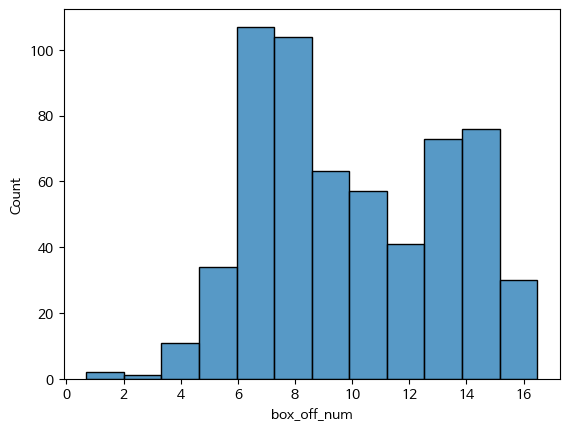

In [ ]:
# 관객수 log 변환 데이터 생성
import numpy as np

train['box_off_num']=np.log1p(train['box_off_num'])

sns.histplot(train['box_off_num'])

# 3. Pycaret
- ML 모델 간의 성능을 비교하기 위해 Pycaret 사용

In [ ]:
!pip install pycaret

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

from pycaret.regression import *
import matplotlib.pyplot as plt

### 회귀 문제 설정

In [ ]:
# 회귀 문제 설정
clf = setup(data=train,
            target='box_off_num',
            normalize=True,
            session_id=42,
            use_gpu=True
            )

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

,Description,Value
0,Session id,42
1,Target,box_off_num
2,Target type,Regression
3,Original data shape,"(599, 55)"
4,Transformed data shape,"(599, 55)"
5,Transformed train set shape,"(419, 55)"
6,Transformed test set shape,"(180, 55)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

###  모델 비교 및 선택

In [ ]:
# 모델 비교 및 선택 : R2 를 기준으로
top3 = compare_models(sort='RMSE', n_select=5, fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.4105,3.5474,1.8805,0.6835,0.2134,0.1967,0.3700
gbr,Gradient Boosting Regressor,1.4370,3.8749,1.9615,0.6541,0.2191,0.1977,0.1700
rf,Random Forest Regressor,1.4632,3.9465,1.9807,0.6477,0.2189,0.2002,0.3800
br,Bayesian Ridge,1.5642,4.0541,2.0079,0.6386,0.2213,0.2085,0.1340
huber,Huber Regressor,1.5771,4.1272,2.0252,0.6324,0.2195,0.2050,0.1580
ridge,Ridge Regression,1.5700,4.1480,2.0291,0.6304,0.2212,0.2058,0.0620
lightgbm,Light Gradient Boosting Machine,1.5444,4.1931,2.0431,0.6248,0.2278,0.2114,0.0900
lar,Least Angle Regression,1.6311,4.3907,2.0902,0.6078,0.2279,0.2105,0.0800
xgboost,Extreme Gradient Boosting,1.5870,4.5049,2.1217,0.5975,0.2397,0.2177,0.2060
omp,Orthogonal Matching Pursuit,1.6650,4.5912,2.1373,0.5906,0.2286,0.2174,0.1200


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

-> et, gbr, rf, br 순으로 좋은 성능

# 모델 적용

## 1. ExtraTreesRegressor

In [ ]:
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
X = train.drop(columns=['box_off_num'])
y = train['box_off_num']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Extra Trees 회귀 모델
et = ExtraTreesRegressor(random_state=42)

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
gridcv = GridSearchCV(et, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
gridcv.fit(X_train, y_train)

print(f"Best Parameters: {gridcv.best_params_}")

Best Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [ ]:
# Validation 데이터 평가
et_best = gridcv.best_estimator_
y_pred_val = et_best.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation RMSE: {val_rmse}")

# 테스트 데이터에 대한 예측 (타겟 없는 데이터)
test_pred = et_best.predict(test)
test_pred_original = np.expm1(test_pred)  # 로그 변환된 타겟을 원래 값으로 변환

# 제출
submission['box_off_num'] = test_pred_original
submission.to_csv('et_submission.csv', index=False)

Validation RMSE: 1.7267616308208587


## 2. Gradient Boost Regressor

In [ ]:
# feature 값과 target 값 분리
X = train.drop(columns=['box_off_num'])
y = train['box_off_num']

In [ ]:
# test 데이터에는 정답이 없으므로 train 데이터를 split하여 성능 평가
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [ ]:
# 파라미터 튜닝 없이 모델 학습/예측/평가
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

# 모델 생성/학습
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000) # seed : 위에 global하게 설정한 것보다 0이 더 좋은 결과
gb_reg.fit(X_train,y_train)

# 예측값 추출
pred0 = gb_reg.predict(X_val)

# 평가 (RMSE)
rmse = np.sqrt(mean_squared_error(y_val, pred0))
print('파라미터 튜닝 없는 gbr RMSE: {0:.4f}'.format(rmse))

파라미터 튜닝 없는 gbr RMSE: 1.8814


In [ ]:
# 파라미터 튜닝 없이 교차  (2.1778)
from sklearn.model_selection import cross_val_score

neg_mse_scores = cross_val_score(gb_reg, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores,2))
print('5 folds의 RMSE scores:', np.round(rmse_scores,2))
print('5 folds의 평균 RMSE:', np.round(avg_rmse,4))

5 folds의 개별 Negative MSE scores: [-5.08 -4.74 -5.08 -4.18 -4.3 ]
5 folds의 RMSE scores: [2.25 2.18 2.25 2.04 2.07]
5 folds의 평균 RMSE: 2.1609


In [ ]:
# 하이퍼 파라미터 튜닝
from sklearn.model_selection import KFold
model = GradientBoostingRegressor()

grid = dict()
grid['n_estimators'] = [100, 500, 1000, 1500]
grid['learning_rate'] = [0.01, 0.05, 0.1, 0.5, 1.0]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [None, 3, 7, 9]

# define the evaluation procedure
cv = KFold(n_splits=5)

# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')

# execute the grid search
grid_result = grid_search.fit(X, y)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -3.464563 using {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}
-4.896832 (0.830826) with: {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 100, 'subsample': 0.5}
-4.892587 (0.771161) with: {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 100, 'subsample': 0.7}
-5.904546 (0.756555) with: {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 100, 'subsample': 1.0}
-3.512414 (0.649651) with: {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.5}
-3.608220 (0.531412) with: {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.7}
-6.135563 (0.699156) with: {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500, 'subsample': 1.0}
-3.601415 (0.536815) with: {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 1000, 'subsample': 0.5}
-3.708907 (0.553081) with: {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 1000, 'subsample': 0.7}
-6.155114 (0.706326) with

In [ ]:
# 교차 검증
from sklearn.model_selection import cross_val_score

gbr = GradientBoostingRegressor(learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5)

scores = cross_val_score(gbr, X, y, scoring='neg_mean_squared_error', cv=5)
rmse = np.sqrt(-1*scores)
avg_rmse = np.mean(rmse)

print('하이퍼 파라미터 튜닝 후 5 Fold 평균 rmse:', np.round(avg_rmse,4))

하이퍼 파라미터 튜닝 후 5 Fold 평균 rmse: 1.8462


## 3. RandomForestRegressor

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
X = train.drop(columns=['box_off_num'])
y = train['box_off_num']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf = RandomForestRegressor(random_state=42)

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gridcv = GridSearchCV(rf, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
gridcv.fit(X_train, y_train)

print(f"Best Parameters: {gridcv.best_params_}")

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# Validation 데이터 평가
rf = gridcv.best_estimator_
y_pred_val = rf.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation RMSE: {val_rmse}")

# 테스트 데이터에 대한 예측 (타겟 없는 데이터)
test_pred = rf.predict(test)
test_pred_original = np.expm1(test_pred)

# 제출
submission['box_off_num'] = test_pred_original
submission.to_csv('rf_submission.csv', index=False)

Validation RMSE: 1.8262078616646182


## 4. Bayesian Ridge

In [ ]:
import pandas as pd
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
X = train.drop(columns=['box_off_num'])
y = train['box_off_num']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
br = BayesianRidge()

params = {
    'alpha_1': [1e-6, 1e-5, 1e-4],
    'alpha_2': [1e-6, 1e-5, 1e-4],
    'lambda_1': [1e-6, 1e-5, 1e-4],
    'lambda_2': [1e-6, 1e-5, 1e-4]
}

gridcv = GridSearchCV(br, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
gridcv.fit(X_train, y_train)

print(f"Best Parameters: {gridcv.best_params_}")


Best Parameters: {'alpha_1': 0.0001, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 0.0001}


In [ ]:
# Validation 데이터 평가
br = gridcv.best_estimator_
y_pred_val = br.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation RMSE: {val_rmse}")

# 테스트 데이터에 대한 예측 (타겟 없는 데이터)
test_pred = br.predict(test)
test_pred_original = np.expm1(test_pred)

# 제출
submission['box_off_num'] = test_pred_original
submission.to_csv('br_submission.csv', index=False)

Validation RMSE: 1.9053663894842294


In [ ]:
submission.head()

,title,box_off_num
0,용서는 없다,270220.4
1,아빠가 여자를 좋아해,366100.5
2,하모니,813747.8
3,의형제,1087701.2
4,평행 이론,990634.7


## Ridge Regrerssion

In [ ]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# 데이터 준비
X = train.drop(columns=['box_off_num'])
y = train['box_off_num']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge 모델 초기화
ridge = Ridge()

# 하이퍼파라미터 그리드 정의
params = {
    'alpha': [0.1, 1, 10, 100]  # 정규화 강도
}

# GridSearchCV 실행
gridcv = GridSearchCV(ridge, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
gridcv.fit(X_train, y_train)

print(f"Best Parameters: {gridcv.best_params_}")

# Validation 데이터 평가
ridge = gridcv.best_estimator_
y_pred_val = ridge.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation RMSE: {val_rmse}")

# 테스트 데이터에 대한 예측 (타겟 없는 데이터)
test_pred = ridge.predict(test)
test_pred_original = np.expm1(test_pred)  # 로그 변환을 풀기 위해 expm1 사용

# 제출
submission['box_off_num'] = test_pred_original
submission.to_csv('ridge_submission.csv', index=False)

Best Parameters: {'alpha': 10}
Validation RMSE: 1.8963401685233814


## XGBoost, LightGBM

In [ ]:
def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X, y)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 parameter:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb_params = {'n_estimators':[100,500,1000],
              'learning_rate':[0.01, 0.05, 0.1, 0.5],
              'subsample':[0.5,0.7,0.8, 1],
              'max_depth':[None, 3,7,9]}
xgb_reg = XGBRegressor()
print_best_params(xgb_reg, xgb_params)

# 13분 32초 소요

XGBRegressor 5 CV 시 최적 평균 RMSE 값:1.8537, 최적 parameter:{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}


In [ ]:
# 교차 검증
from sklearn.model_selection import cross_val_score

xgbr = XGBRegressor(learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.7)

scores = cross_val_score(gbr, X, y, scoring='neg_mean_squared_error', cv=5)
rmse = np.sqrt(-1*scores)
avg_rmse = np.mean(rmse)

print('하이퍼 파라미터 튜닝 후 5 Fold 평균 rmse:', np.round(avg_rmse,4))

하이퍼 파라미터 튜닝 후 5 Fold 평균 rmse: 1.8594


In [ ]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[100,500,1000],
               'learning_rate':[0.01, 0.05, 0.1, 0.5],
              'subsample':[0.5,0.7,1],
              'max_depth':[None, 3,7,9]}
lgbm_reg = LGBMRegressor(colsample_bytree=0.7, n_jobs=-1, verbose=-1)
print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값:1.8895, 최적 parameter:{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.5}


In [ ]:
# 교차 검증
lgbmr = LGBMRegressor(learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5, colsample_bytree=0.7, n_jobs=-1, verbose=-1)

scores = cross_val_score(gbr, X, y, scoring='neg_mean_squared_error', cv=5)
rmse = np.sqrt(-1*scores)
avg_rmse = np.mean(rmse)

print('하이퍼 파라미터 튜닝 후 5 Fold 평균 rmse:', np.round(avg_rmse,4))

하이퍼 파라미터 튜닝 후 5 Fold 평균 rmse: 1.8468


# 블랜딩

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, BayesianRidge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
# 데이터 준비
X = train.drop(columns=['box_off_num'])
y = train['box_off_num']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 1. 개별 모델 학습
# ElasticNet
et = ExtraTreesRegressor(bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200)
et.fit(X_train, y_train)
et_val_pred = et.predict(X_val)

# GradientBoostingRegressor
gbr = GradientBoostingRegressor(learning_rate = 0.01, max_depth = 3, n_estimators = 500, subsample = 0.7)
gbr.fit(X_train, y_train)
gbr_val_pred = gbr.predict(X_val)

# RandomForestRegressor
rf = RandomForestRegressor(max_depth = 20, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200)
rf.fit(X_train, y_train)
rf_val_pred = rf.predict(X_val)

# BayesianRidge
br = BayesianRidge(alpha_1 = 0.0001, alpha_2 = 1e-06, lambda_1 = 1e-06, lambda_2 = 0.0001)
br.fit(X_train, y_train)
br_val_pred = br.predict(X_val)

# Ridge Regression
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)
ridge_val_pred = ridge.predict(X_val)

# XGBoost
xgb = XGBRegressor(learning_rate = 0.01, max_depth = 3, n_estimators = 1000, subsample = 0.5)
xgb.fit(X_train, y_train)
xgb_val_pred = xgb.predict(X_val)

# LightGBM
lgbm = LGBMRegressor(learning_rate = 0.01, max_depth = 7, n_estimators = 100, subsample = 0.5)
lgbm.fit(X_train, y_train)
lgbm_val_pred = lgbm.predict(X_val)

In [ ]:
# 2. 개별 모델의 예측값 합치기
# Stack predictions
val_preds = np.column_stack([et_val_pred, gbr_val_pred, rf_val_pred, br_val_pred, ridge_val_pred, xgb_val_pred, lgbm_val_pred])

In [ ]:
# 3. 블렌딩을 위한 메타 모델 생성
# Bayesian Ridge를 메타 모델로 사용
meta_model = BayesianRidge()
meta_model.fit(val_preds, y_val)

BayesianRidge()

In [ ]:
# 4. 최종 예측
# Test 데이터에 대한 예측 (각 모델로 개별 예측 후 블렌딩)
et_test_pred = et.predict(test)
gbr_test_pred = gbr.predict(test)
rf_test_pred = rf.predict(test)
br_test_pred = br.predict(test)
ridge_test_pred = ridge.predict(test)
xgb_test_pred = xgb.predict(test)
lgbm_test_pred = lgbm.predict(test)

test_preds = np.column_stack([et_test_pred, gbr_test_pred, rf_test_pred, br_test_pred, ridge_test_pred, xgb_test_pred, lgbm_test_pred])
final_test_pred = meta_model.predict(test_preds)

In [ ]:
# 5. 제출 준비
final_test_pred_original = np.expm1(final_test_pred)
submission['box_off_num'] = final_test_pred_original
submission.to_csv('Blending_submission.csv', index=False)